<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/master/exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (EDA)

In [1]:
!git clone https://github.com/arunraja-hub/Preference_Extraction.git

Cloning into 'Preference_Extraction'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 784 (delta 25), reused 6 (delta 6), pack-reused 743
Receiving objects: 100% (784/784), 32.21 MiB | 18.85 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [0]:
# Main Notebook Imports
import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import scipy
from scipy import ndimage
from sklearn import metrics
from sklearn.utils import shuffle
import io
import collections

import urllib.request
from urllib.error import HTTPError

In [3]:
# EDA Imports
import pandas as pd
import seaborn as sns
import joblib

sns.set(style="white")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Each trajectory object can be thought of us as a memory element in DQN 

*   memory=state,action,reward,next_state,done




In [0]:
class Trajectory(
    collections.namedtuple('Trajectory', [
        'step_type',
        'observation',
        'action',
        'policy_info',
        'next_step_type',
        'reward',
        'discount',
    ])):
  """Stores the observation the agent saw and the action it took.
      The rest of the attributes aren't used in this code."""
  __slots__ = ()

class ListWrapper(object):
  def __init__(self, list_to_wrap):
    self._list = list_to_wrap

  def as_list(self):
    return self._list

class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
      if name == "Trajectory":
        return Trajectory
      if name == "ListWrapper":
        return ListWrapper

      return super(RenameUnpickler, self).find_class(module, name)

def rename_load(s):
    """Helper function analogous to pickle.loads()."""
    return RenameUnpickler(s, encoding='latin1').load()

In [0]:
# Modified read trajectories functions to read files from local storage

def load_file(full_path):
    try:
        with open(full_path, 'rb') as f:
            data = rename_load(f)
            return data
    except:
        return None
    
def all_load_data(base_path):
    
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    
    futures = []
    for i in range(5000):
        full_path = os.path.join(base_path, "ts"+str(i)+".pickle")
        future = executor.submit(load_file, full_path)
        futures.append(future)
    
    raw_data = []
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            raw_data.append(result)
    
    return raw_data


all_raw_data = all_load_data("Preference_Extraction/data/simple_env_1/")

475 trajectories in total

In [6]:
len(all_raw_data)

475

In [0]:
activations = []
observations = []
preferences = []

What is the shape of observations, activations and preferences?

In [8]:
print('shape of observations: ',all_raw_data[0].observation.shape)
print('shape of activations: ',all_raw_data[0].policy_info["activations"].shape)
print('shape of preferences: ',len(all_raw_data[0].policy_info["satisfaction"].as_list()))

shape of observations:  (50, 14, 16, 5)
shape of activations:  (50, 64)
shape of preferences:  50


In [0]:
# Load up data into arrays
for data in all_raw_data:
    for i in range(data.observation.shape[0]):# range(50)
        observations.append(np.copy(data.observation[i]))
        activations.append(np.copy(data.policy_info["activations"][i]))
        preferences.append(data.policy_info['satisfaction'].as_list()[i])

observations = np.array(observations)
activations = np.array(activations)
preferences = np.array(preferences)

In [10]:
assert activations.shape[0] == 475 * 50
print(observations.shape)
print(activations.shape)
print(preferences.shape)

(23750, 14, 16, 5)
(23750, 64)
(23750,)


## Activations

Some findings:
* There are only 22 activations that are non-zero throughout all 475 trajectories and 50 steps (475*50)
* Among these are are 9 activations with double digit means, most of which have average values in the 25-55 range
* Among these, we can find both significant positive (fire together) and negative (fire alternate) correlations

In [0]:
act_df = pd.DataFrame(activations)

In [12]:
# Non-zero activations count
(act_df.max(axis=0) > 0).sum()

22

In [0]:
non_zero_acts = act_df.loc[:,act_df.max() > 0]

In [14]:
non_zero_acts.mean(axis=0).sort_values(ascending=False)

44    108.166695
4      70.367706
34     54.649296
36     47.765011
21     44.762753
61     43.369133
7      37.902599
11     24.539474
41     13.002387
27      7.812490
38      7.647850
17      4.370120
22      3.613050
13      3.217230
57      2.255843
48      1.905998
31      1.613340
60      1.390754
35      0.013170
1       0.007774
16      0.000193
58      0.000163
dtype: float32

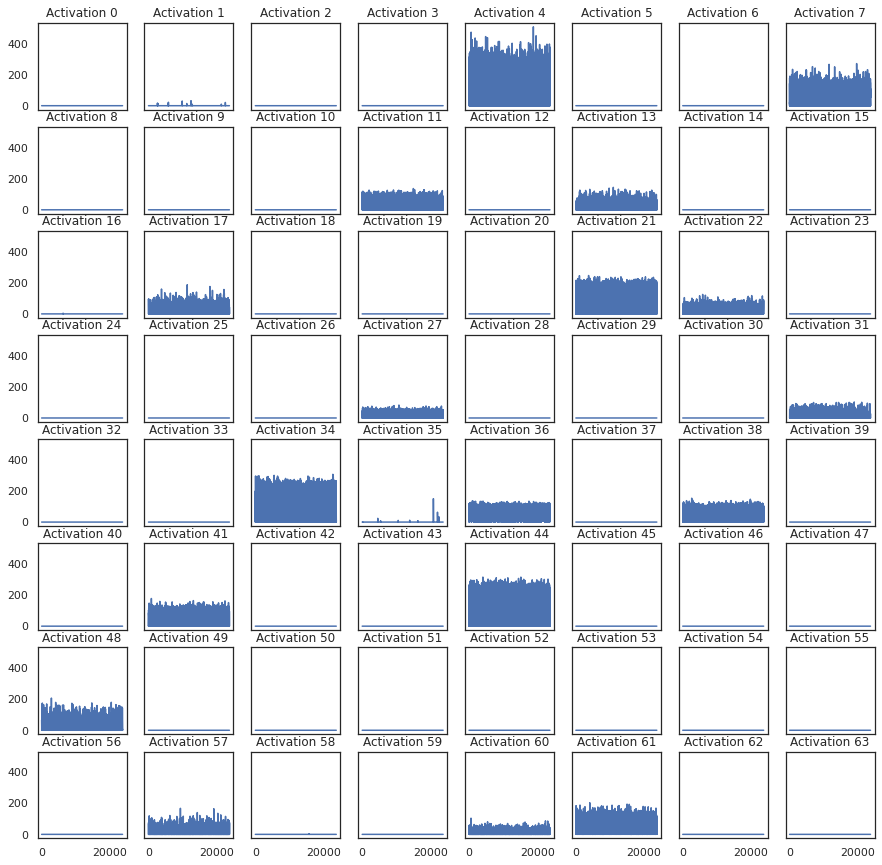

In [15]:
# Activations plots
fig, axs = plt.subplots(8, 8, figsize=(15, 15), sharex=True, sharey=True)
for x in range(activations.shape[1]):
    axs[int(x/8), x%8].plot(activations[:,x])
    axs[int(x/8), x%8].set_title('Activation {}'.format(x))
for ax in fig.get_axes():
    ax.label_outer()
plt.show()

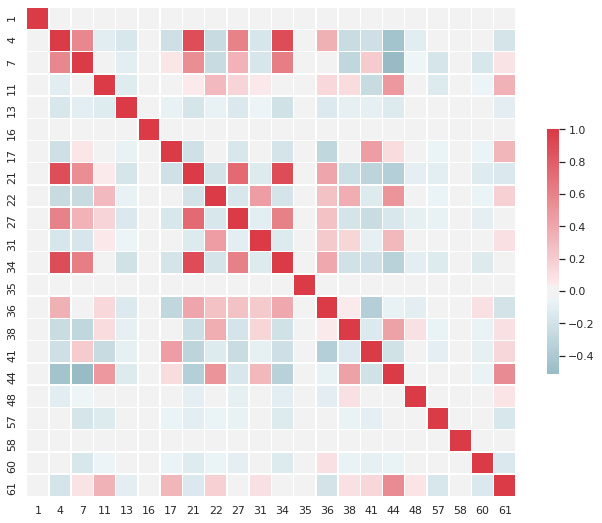

In [16]:
# Activations correlations heatmap
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(non_zero_acts.corr(), cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Othorgonal (i.e 0 correlations) activations are mostly due to those few non-zero activations with very low values (e.g. 1, 16, 31, 35, 48, 57, 58, 60)

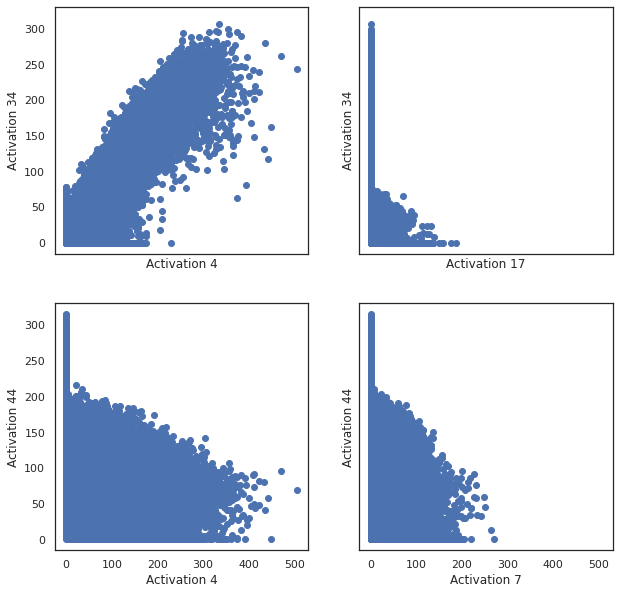

In [17]:
# Activations plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

axs[0, 0].scatter(activations[:,4], activations[:,34])
axs[0, 0].set_xlabel('Activation 4')
axs[0, 0].set_ylabel('Activation 34')

axs[1, 0].scatter(activations[:,4], activations[:,44])
axs[1, 0].set_xlabel('Activation 4')
axs[1, 0].set_ylabel('Activation 44')

axs[0, 1].scatter(activations[:,17], activations[:,34])
axs[0, 1].set_xlabel('Activation 17')
axs[0, 1].set_ylabel('Activation 34')

axs[1, 1].scatter(activations[:,7], activations[:,44])
axs[1, 1].set_xlabel('Activation 7')
axs[1, 1].set_ylabel('Activation 44')

plt.show()

## Activations & Preferences

In [0]:
prefs = pd.Series(preferences)

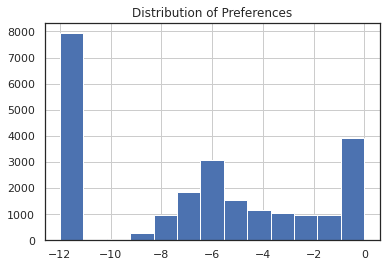

In [19]:
plt.title('Distribution of Preferences')
prefs.replace(-100, -12).hist(bins=len(prefs.value_counts()))
plt.show()

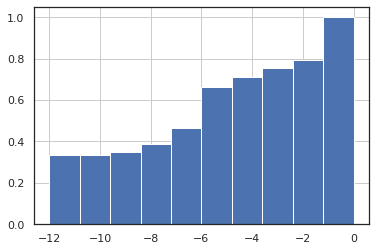

In [20]:
prefs.replace(-100, -12).hist(cumulative=True, density=1)

The distribution of preferences above (where I replaced -100 with -12 for illustration purposes) tells us that
* 33% of values are -100
* 13% of values are above -100 and below -6
* The remaining 53% of preferences are equal or above -6

This distribution is relevant for us because we can see that the most correlated activation (in absolute value) with preferences, is non-zero whenever preferences are -100 for 97% of the times.

Thus, using this activation to tell if preferences are -100 would be almost perfect. It is then likely that the harder part of our preferences extraction task is to predict the 13% of time when preferences are above -100 and below -6 (given that our taks is a binary "predict greater than -6" task)

In [21]:
non_zero_acts.corrwith(prefs).sort_values()

21   -0.893958
34   -0.795727
27   -0.755302
4    -0.742602
7    -0.572725
36   -0.254596
11   -0.191985
35   -0.015347
58   -0.009149
16    0.004137
1     0.009280
61    0.023226
48    0.105374
57    0.108007
60    0.115908
31    0.122526
22    0.185601
17    0.195930
13    0.196373
38    0.211261
44    0.271434
41    0.308715
dtype: float64

In [22]:
1 - sum(abs((non_zero_acts[21] > 0).astype(int).values - (prefs==-100).astype(int).values)) / len(non_zero_acts)

0.9741052631578947

In [23]:
"""
Accuracy of predicting if preferences are -100, simply by checking if activation 21 is > 0
This cell will give the accuracy with a different sample of 50 data points every time is run
"""
df_21_prefs = pd.DataFrame(list(zip(non_zero_acts[21].values > 0, preferences == -100)), columns=[21, 'prefs'])
(1 - (df_21_prefs.sample(50).sum(axis=1) % 2).sum() / 50)

1.0

Let us then turn our attention to preferences other than -100

In [0]:
pref_ab_m100 = prefs[prefs > -100]

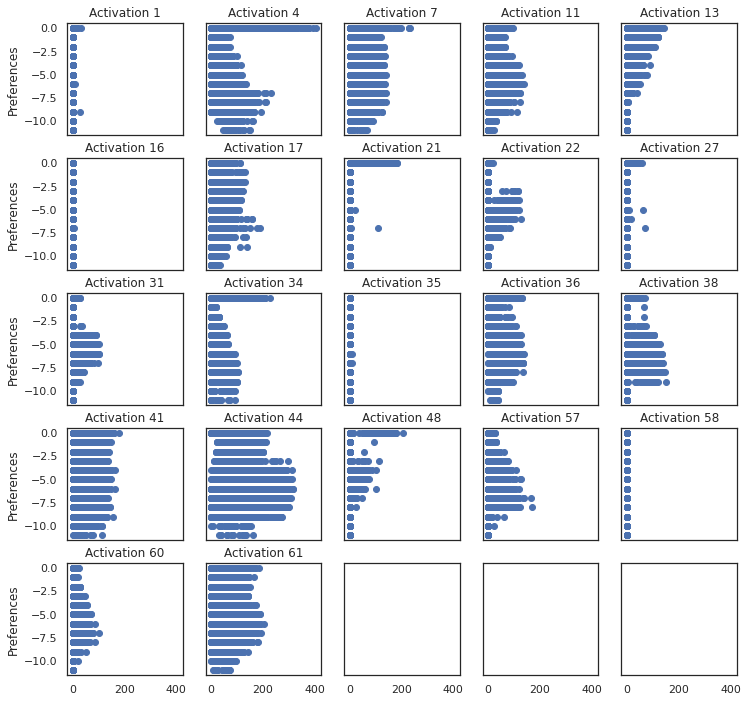

In [25]:
# Activations/Preferences plots
fig, axs = plt.subplots(5, 5, figsize=(12, 12), sharex=True, sharey=True)

for ix, x in enumerate(list(non_zero_acts)):
    axs[int(ix/5), ix%5].scatter(non_zero_acts.loc[pref_ab_m100.index.values,x], pref_ab_m100)
    axs[int(ix/5), ix%5].set_title('Activation {}'.format(non_zero_acts.loc[:,x].name))
    axs[int(ix/5), ix%5].set_ylabel('Preferences')
for ax in fig.get_axes():
    ax.label_outer()
plt.show()

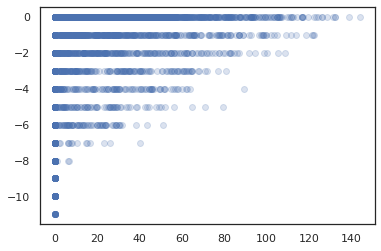

In [26]:
plt.scatter(non_zero_acts.loc[pref_ab_m100.index.values, 13], pref_ab_m100, alpha=0.2)

What we can see from the plots above, is that for no activation there is a clear separation around -6, making it thus very difficult to tell apart which values are below -6 and which are greater or equal (given that they are all above -12).

Some interesting indications
* When activation 44 is zero, we not that preferences are not -1, -2 or -3
* Activation 57 fires more often with values between -3 and -8
* Activation 21 (again) fires mostly when preferences are 0 (but less accurate in this case, about 70% of the time)
* Activation 13 has a stark preferences for values above -6, however 90% of its values when preferences are above -12 are 0 